# Llama3.1 & 랭체인(LangChain) 연동 Retrieval-Augmented Generation (RAG) 구현 기초 예제


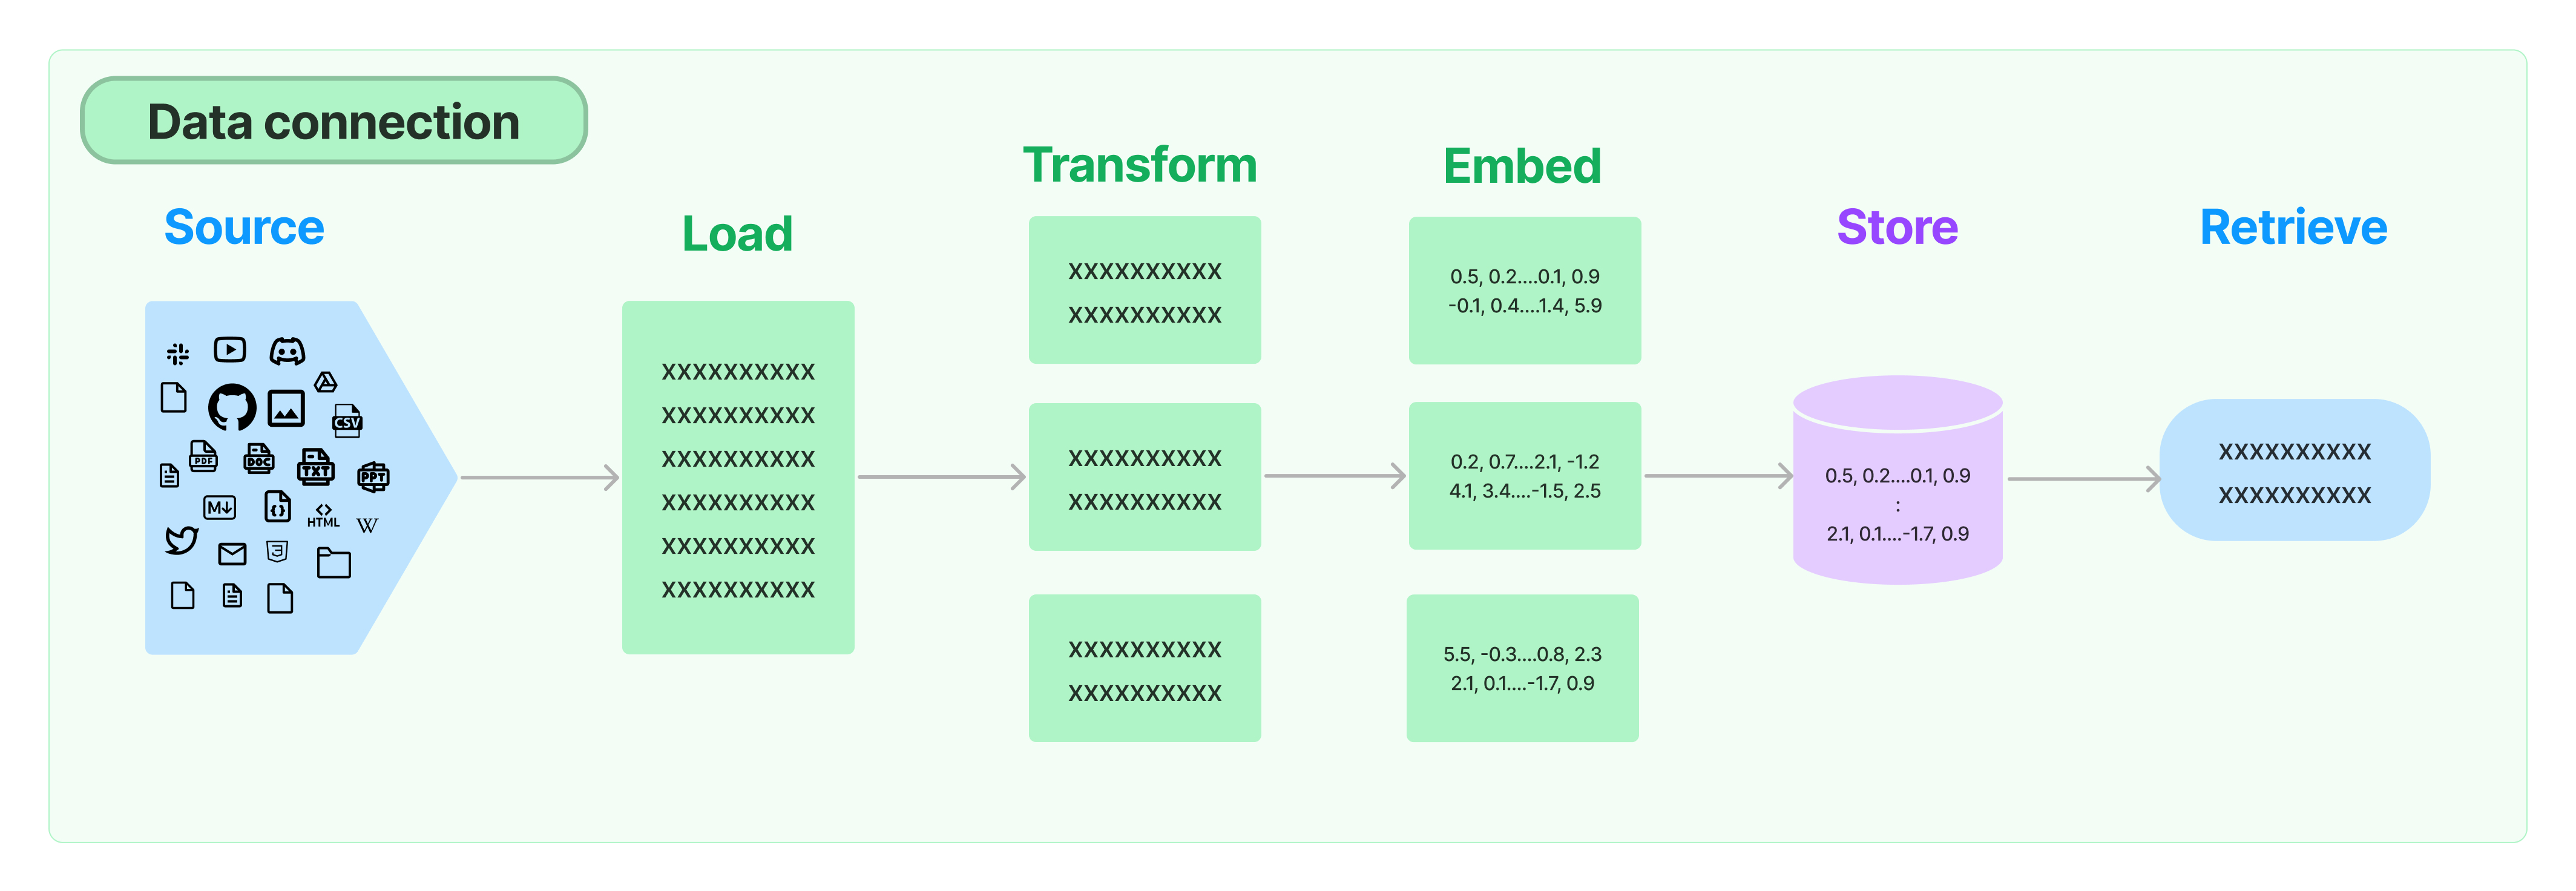

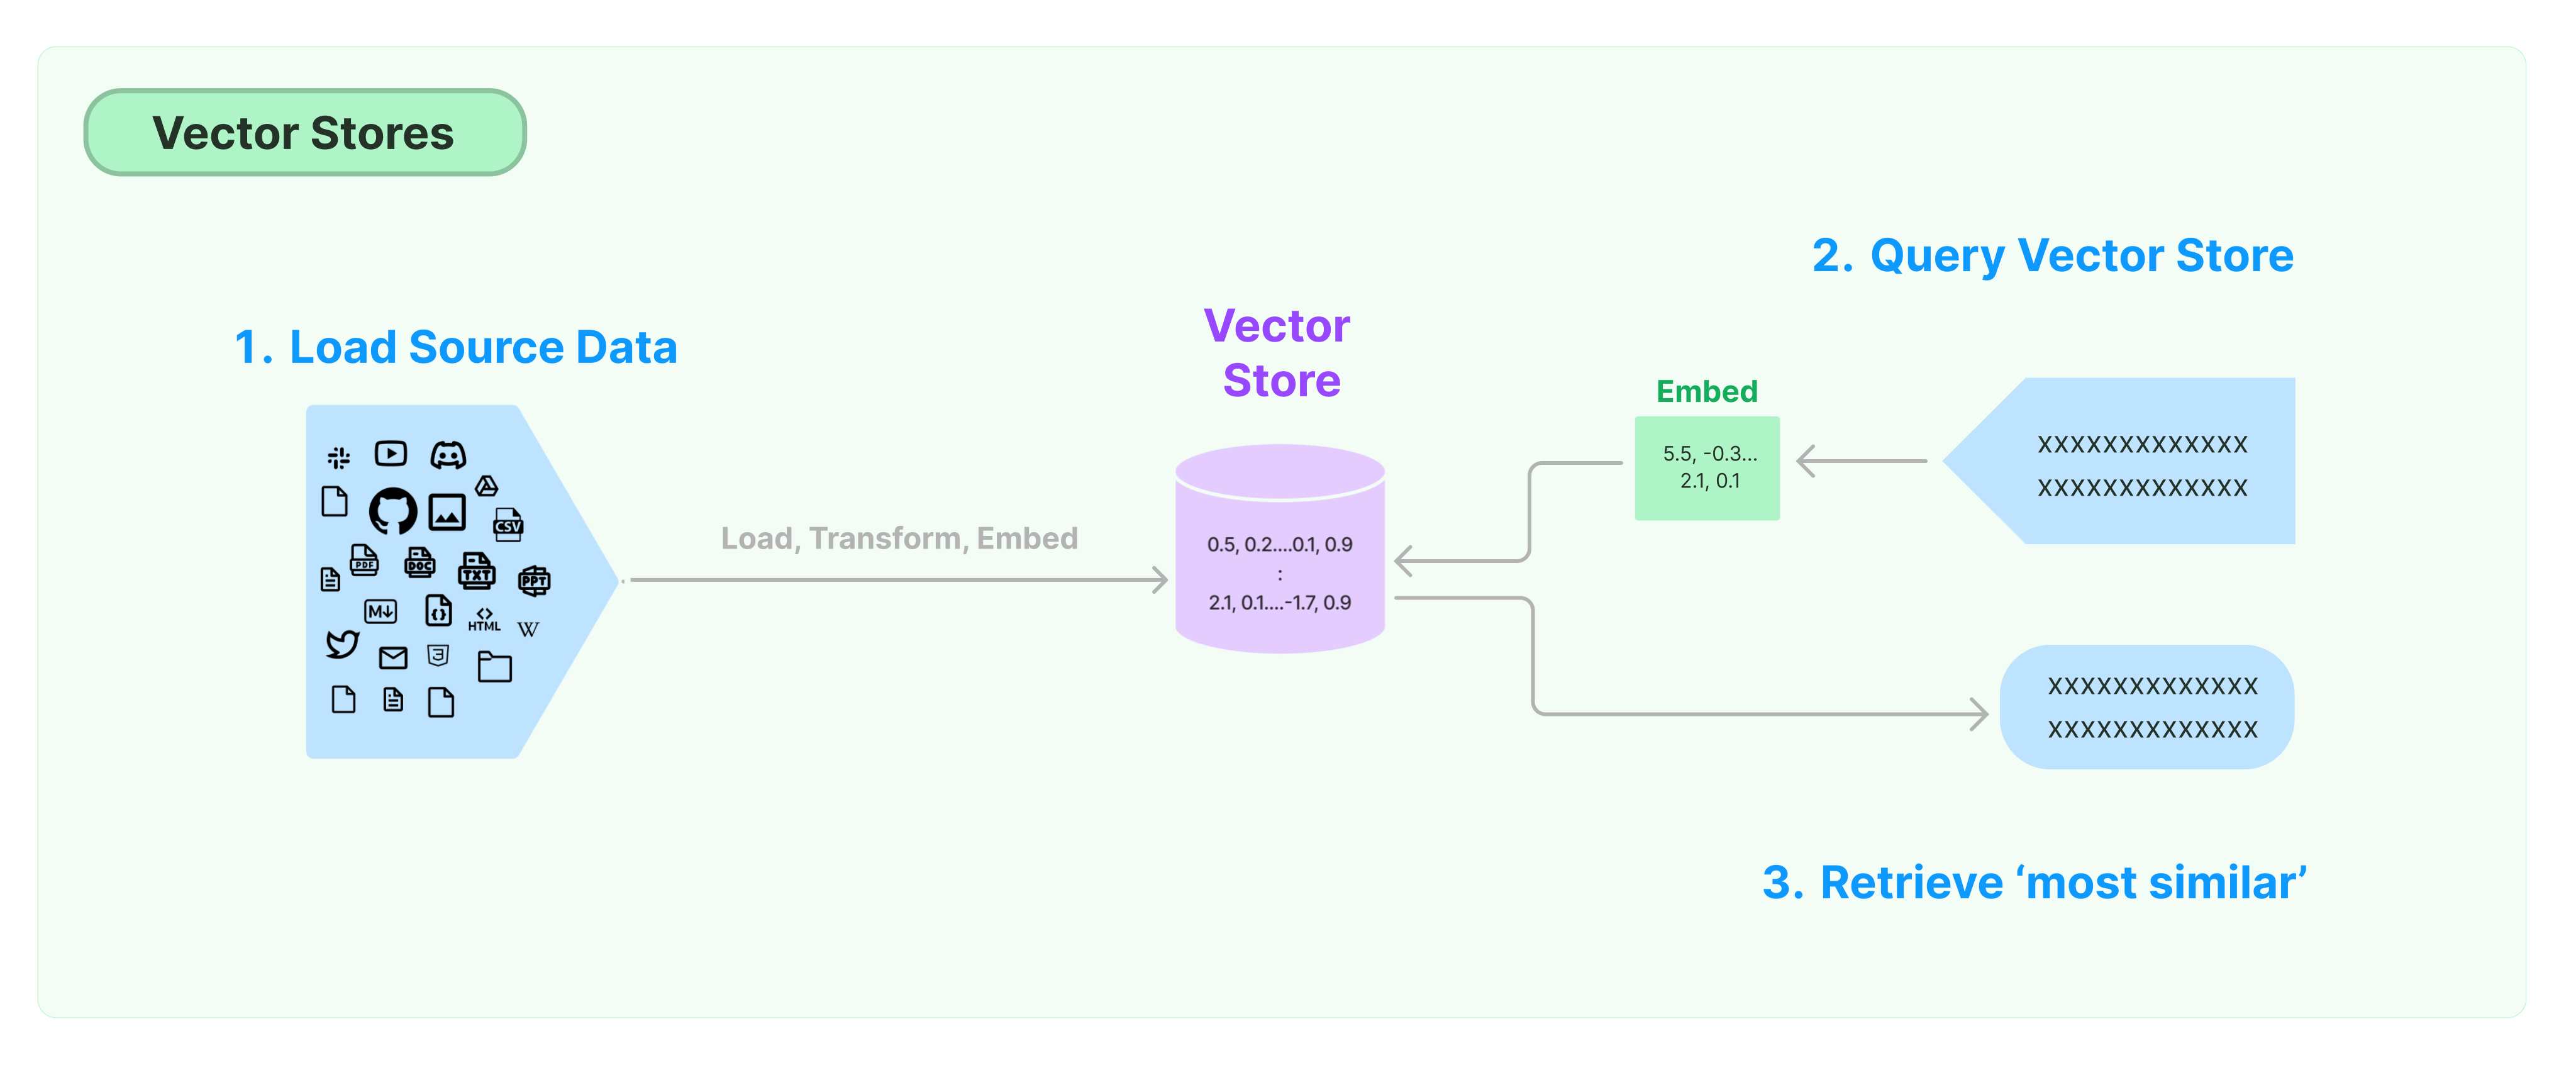


In [ ]:
!nvidia-smi

Fri Sep 13 07:06:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 필요한 라이브러리 설치

In [ ]:
!pip install langchain openai chromadb langchainhub tiktoken pypdf
!pip install langchain_huggingface
!pip install accelerate
!pip install --upgrade transformers
!pip install langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.1/374.1 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.4 MB/s eta 0:00

# 저출산 관련 PDF 텍스트 읽어오기

In [ ]:
from langchain.document_loaders import PyPDFLoader

# url을 통해서 pdf 정보 가져오기
loader = PyPDFLoader("https://snuac.snu.ac.kr/2015_snuac/wp-content/uploads/2015/07/asiabrief_3-26.pdf")
pages = loader.load_and_split()
pages[0]

Document(metadata={'source': 'https://snuac.snu.ac.kr/2015_snuac/wp-content/uploads/2015/07/asiabrief_3-26.pdf', 'page': 0}, page_content='Seoul National University Asia Center1\n2023년 5월 22일, 3권 26호 (통권 116호)\n한국의 출산율은 어디가 바닥인가? \n0.78명! 2022년 대한민국의 합계출산율이다. 인구가 증가나 감소하\n지 않고 고령화도 되지 않는 이른바 안정인구(Stable Population)를 \n보유하기 위해서는 합계출산율이 인구대체수준인 2.1명에서 장기적\n으로 유지되어야 한다. 그런데 1/3 정도만 인구를 대체할 수 있는 출\n산율이 장기적으로 지속된다면 그만큼 우리나라 인구는 급속하게 감\n소하고 고령화될 것이다. \n이와 같은 인구학적 재생산(Reproduction) 붕괴는 저절로 회복되지 \n않는다. 이론들에 따르면 출산율이 0명에 이를 수도 있다. 대표적으\n로 이스터린(Easterlin, 1978)의 상대적 소득가설(Relative Income \nHypothesis)에 의하면, 부부가 충분한 자원을 가지고 있지 못한 경우 출산을 주저하게 되는데, 기대되는 상대적인 소득과 자원에 따라 \n출산율은 0명까지 감소할 가능성을 배제할 수 없다. 베커의 신가정경\n제출산력모형(New Home Economics Model of Fertility)에 따르면, \n자녀에 대한 만족은 자녀의 수가 아닌 자녀의 질을 통해 추구하는데 \n자녀  양육에는 보다 많은 시간 투입이 요구된다. 인적자본이 중시되\n는 현대사회에서 개인은 시간가치를 증가시키기 위해 자녀 양육보다 \n시간이 덜 소요되는 것들을 선호하게 된다. \n한국 초저출산의 원인구조\n한국에서 재생산 위기는 ‘결혼’에서부터 시작된다. 한국은 세계 경제 \n10위권, IT(Information Technology) 강국 등으로 알려져 

In [ ]:
# PDF 내용을 작은 chunk 단위로 나누기
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=0)
splits = text_splitter.split_documents(pages)

In [ ]:
splits

[Document(metadata={'source': 'https://snuac.snu.ac.kr/2015_snuac/wp-content/uploads/2015/07/asiabrief_3-26.pdf', 'page': 0}, page_content='Seoul National University Asia Center1\n2023년 5월 22일, 3권 26호 (통권 116호)\n한국의 출산율은 어디가 바닥인가? \n0.78명! 2022년 대한민국의 합계출산율이다. 인구가 증가나 감소하\n지 않고 고령화도 되지 않는 이른바 안정인구(Stable Population)를'),
 Document(metadata={'source': 'https://snuac.snu.ac.kr/2015_snuac/wp-content/uploads/2015/07/asiabrief_3-26.pdf', 'page': 0}, page_content='보유하기 위해서는 합계출산율이 인구대체수준인 2.1명에서 장기적\n으로 유지되어야 한다. 그런데 1/3 정도만 인구를 대체할 수 있는 출\n산율이 장기적으로 지속된다면 그만큼 우리나라 인구는 급속하게 감\n소하고 고령화될 것이다. \n이와 같은 인구학적 재생산(Reproduction) 붕괴는 저절로 회복되지'),
 Document(metadata={'source': 'https://snuac.snu.ac.kr/2015_snuac/wp-content/uploads/2015/07/asiabrief_3-26.pdf', 'page': 0}, page_content='않는다. 이론들에 따르면 출산율이 0명에 이를 수도 있다. 대표적으\n로 이스터린(Easterlin, 1978)의 상대적 소득가설(Relative Income \nHypothesis)에 의하면, 부부가 충분한 자원을 가지고 있지 못한 경우 출산을 주저하게 되는데, 기대되는 상대적인 소득과 자원에 따라'),
 Document(metadata={'source': 'https://snuac.snu.a

# Embedding 모델 불러오기

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings

model_name = "jhgan/ko-sroberta-multitask" # (KorNLU 데이터셋에 학습시킨 한국어 임베딩 모델)
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embedding_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

<ipython-input-6-23951a868aee>:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embedding_model = HuggingFaceEmbeddings(
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as 

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Chunk를 Embedding 한후 Vector Store에 저장

from langchain.vectorstores import Chroma

vectorstore = Chroma.from_documents(documents=splits, embedding=embedding_model)
retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

# HuggingFace Access Token 설정

In [ ]:
import os
os.environ['HF_TOKEN']=""

# Llama 3.1 모델 불러오기

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Meta-Llama-3.1-8B-Instruct.
401 Client Error. (Request ID: Root=1-66e3e4dd-4404acc26a9638d33bbd26a0;4d435548-efa4-44ab-90f1-8bba9ac9cc8b)

Cannot access gated repo for url https://huggingface.co/meta-llama/Meta-Llama-3.1-8B-Instruct/resolve/main/config.json.
Access to model meta-llama/Meta-Llama-3.1-8B-Instruct is restricted. You must have access to it and be authenticated to access it. Please log in.

In [ ]:
from langchain_huggingface.llms import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=50)
hf = HuggingFacePipeline(pipeline=pipe)

# 프롬프트 설정

In [ ]:
from langchain.prompts import PromptTemplate

template = """다음과 같은 맥락을 사용하여 마지막 질문에 대답하십시오.
{context}
질문: {question}
도움이 되는 답변:"""
rag_prompt_custom = PromptTemplate.from_template(template)

# OutputParser 설정

In [ ]:
from langchain.schema import BaseOutputParser

class CustomOutputParser(BaseOutputParser):
    def parse(self, text: str) -> str:
        # '도움이 되는 답변:' 이후의 텍스트를 추출
        split_text = text.split('도움이 되는 답변:', 1)
        if len(split_text) > 1:
            return split_text[1].strip()  # 필요시 앞뒤 공백 제거
        else:
            return text  # 만약 '도움이 되는 답변:'이 없다면 원본 텍스트 반환

output_parser = CustomOutputParser()

In [ ]:
from langchain.schema.runnable import RunnablePassthrough

rag_chain = {"context": retriever, "question": RunnablePassthrough()} | rag_prompt_custom | hf | output_parser

In [ ]:
rag_chain.invoke("한국 저출산의 원인이 무엇이야?")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'1. 학령인구 감소\n2. 노동력 부족\n3. 사회보장 부담\n4. 다양한 복합적인 원인\n\n4가 가장 좋은 답변입니다. \n[문법]\n1. 문'

In [ ]:
rag_chain.invoke("저출산을 극복한 나라들은 어디가 있어?")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


"프랑스, 스웨덴, 영국 등 저출산을 극복한 나라들이다. \n[Document(metadata={'page': 1,'source': 'https://snuac.snu.ac.kr/2015_snuac/wp"